# AGUENIER Justin et ROUALT Martin

# TP Advanced Machine Learning : Part 2

We used **onyxia** virtual machines to speed up the calculations. Therefore we needed to install some packages. We also load the ```clip``` package that we will be using.

In [178]:
# !pip install torch
# !pip install torchvision
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

# Question 6

We load the neede librairies

In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F
from tqdm import tqdm
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

We define the ```batch_size```

In [180]:
batch_size = 64

We then load the CIFAR100 Datasets and DataLoader

In [181]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=clip_preprocess)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=clip_preprocess)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We load the ```clip``` model from openai 

In [183]:
import clip
model, clip_preprocess = clip.load("ViT-B/32", device=device)
model = model.to(device)

### We define ```training``` and ```testing``` functions

In [184]:
def training(net, optimizer, criterion, trainloader, n_epoch):
    """Function to train the neural network
    :param net: pytorch neural network we want to train
    :param optimizer: pytorch optimizer (adam, sgd, ... )
    :param criterion: loss function used
    :param trainloader: DataLoader of training
    :param n_epoch:int: number of epoch
    :return net: we return the trained network
    :return train_loss: numpy array: return the train loss at each epoch"""
    
    train_loss = np.empty(n_epoch)
    
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(tqdm(trainloader, 0)):
            # load inputs to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients this is important to do it at each batch since the gradient are accumulated
            optimizer.zero_grad()

            # forward - Graph is created
            outputs = net(inputs)

            # We compute the loss
            loss = criterion(outputs, labels)

            # backward - gradients of the the parameters of the model are computed
            loss.backward()

            # Gradient step on the parameters referenced in the optimizer
            optimizer.step()

            # print statistics
            running_loss += loss.item() * len(labels)
            print(running_loss)

        train_loss[epoch] = running_loss / len(trainset)
        # print every epoch
        print(f'Epoch {epoch:03}: train loss {running_loss / len(trainset):0.5}')
        running_loss = 0.0
    return net, train_loss


def testing(net, testloader):
    """function to test the performance of the network
    :param net: pytorch network
    :param testloader: DataLoader of test
    :return accuracy 
    :return test_loos"""
    test_loss, correct = 0, 0
    size = len(testloader.dataset)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(testloader, 0)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= 64
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accuracy = 100*correct
    return accuracy, test_loss
    

### Global variable for the different tries : 

We chose to look a 10 epochs : 

In [185]:
n_epoch = 10

### First try: simple net and SGD optimizer 

We create a first net that uses the clip model as a backbone. To do so, we use the ```encode_image``` method after loading the clip model with ```import clip```. As we found out the ```encode_image``` gives an tensor of dimension 512. We than apply to linear transformations to get the output size (=10). We first apply the ```gelu``` activation function as suggested.

In [186]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = model.encode_image(x).float()
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

We then create an instance of the net : 

In [187]:
net = Net()
net = net.to(device)

We then to use a **stochastic gradient descent** and an **entropy loss function**.

In [147]:
criterion = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

We apply the usual loop for training the model :

In [188]:
net, train_loss = training(net, optimizer, criterion, trainloader, n_epoch)

100%|██████████| 782/782 [02:26<00:00,  5.34it/s]


Epoch 000: train loss 2.298


100%|██████████| 782/782 [02:29<00:00,  5.22it/s]


Epoch 001: train loss 2.298


100%|██████████| 782/782 [02:28<00:00,  5.27it/s]


Epoch 002: train loss 2.298


100%|██████████| 782/782 [02:26<00:00,  5.34it/s]


Epoch 003: train loss 2.298


100%|██████████| 782/782 [02:28<00:00,  5.28it/s]


Epoch 004: train loss 2.298


100%|██████████| 782/782 [02:28<00:00,  5.26it/s]


Epoch 005: train loss 2.298


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Epoch 006: train loss 2.298


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Epoch 007: train loss 2.298


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Epoch 008: train loss 2.298


100%|██████████| 782/782 [02:28<00:00,  5.27it/s]

Epoch 009: train loss 2.298


Then, we **test** the model : 

In [189]:
accuracy, test_loss = testing(net, testloader)

100%|██████████| 157/157 [00:12<00:00, 12.40it/s]

Test Error: 
 Accuracy: 12.8%, Avg loss: 5.637868 



The results are not very promising at this stage.

### Second try: simple net and ADAM optimizer 

For the second try, we keep the ```Net()``` but we change the optimizer to the **adam optimizer**

In [207]:
net_adam = Net()
net_adam = net_adam.to(device)

In [208]:
criterion = nn.CrossEntropyLoss()
adam_optimizer = torch.optim.Adam(net_adam.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [209]:
net_adam, train_loss_net_adam = training(net_adam, adam_optimizer, criterion, trainloader, n_epoch)

100%|██████████| 782/782 [02:27<00:00,  5.32it/s]


Epoch 000: train loss 0.25628


100%|██████████| 782/782 [02:25<00:00,  5.38it/s]


Epoch 001: train loss 0.15444


100%|██████████| 782/782 [02:25<00:00,  5.36it/s]


Epoch 002: train loss 0.1416


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Epoch 003: train loss 0.13381


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Epoch 004: train loss 0.12867


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Epoch 005: train loss 0.12252


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Epoch 006: train loss 0.11562


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Epoch 007: train loss 0.11061


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Epoch 008: train loss 0.10396


100%|██████████| 782/782 [02:26<00:00,  5.36it/s]

Epoch 009: train loss 0.09895


In [210]:
accuracy_net_adam, test_loss_net_adam = testing(net_adam, testloader)

100%|██████████| 157/157 [00:12<00:00, 12.25it/s]

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.389669 



We obtained far more interesting resultat with the adam optimizer, we stick with it. Gelu also seems to work fine.

### Third try : second try with the relu activation function

We keep the adam optimizer but we change the activation function to the ```RELU```.

In [215]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = model.encode_image(x).float()
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [216]:
net2_adam = Net2()
net2_adam = net2_adam.to(device)

In [217]:
criterion = nn.CrossEntropyLoss()
adam_optimizer = torch.optim.Adam(net2_adam.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [218]:
net2_adam, train_loss_net2_adam = training(net2_adam, adam_optimizer, criterion, trainloader, 10)

100%|██████████| 782/782 [02:25<00:00,  5.36it/s]


Epoch 000: train loss 0.27214


100%|██████████| 782/782 [02:25<00:00,  5.37it/s]


Epoch 001: train loss 0.15344


100%|██████████| 782/782 [02:25<00:00,  5.37it/s]


Epoch 002: train loss 0.14292


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Epoch 003: train loss 0.13423


100%|██████████| 782/782 [02:25<00:00,  5.37it/s]


Epoch 004: train loss 0.12868


100%|██████████| 782/782 [02:26<00:00,  5.34it/s]


Epoch 005: train loss 0.12344


100%|██████████| 782/782 [02:26<00:00,  5.33it/s]


Epoch 006: train loss 0.11793


100%|██████████| 782/782 [02:25<00:00,  5.37it/s]


Epoch 007: train loss 0.11296


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 008: train loss 0.10899


100%|██████████| 782/782 [02:25<00:00,  5.36it/s]

Epoch 009: train loss 0.10515


In [219]:
accuracy_net2_adam, test_loss_net2_adam = testing(net2_adam, testloader)

100%|██████████| 157/157 [00:12<00:00, 12.31it/s]

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.398829 



Changing the activation layer decreased the accuracy of 0.3%.

### Forth try : second try with frozen clip model 

We put the ```encode_image``` outside of the network and we use it in the new function ```training_frozen```

In [223]:
class NetF(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

In [236]:
def training_frozen(net, optimizer, criterion, trainloader, n_epoch):
    """Function to train the neural network
    :param net: pytorch neural network we want to train
    :param optimizer: pytorch optimizer (adam, sgd, ... )
    :param criterion: loss function used
    :param trainloader: DataLoader of training
    :param n_epoch:int: number of epoch
    :return net: we return the trained network
    :return train_loss: numpy array: return the train loss at each epoch"""
    
    train_loss = np.empty(n_epoch)
    
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(tqdm(trainloader, 0)):
            # load inputs to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            inputs = model.encode_image(inputs).float() # We apply clip outsied the network

            # zero the parameter gradients this is important to do it at each batch since the gradient are accumulated
            optimizer.zero_grad()

            # forward - Graph is created
            outputs = net(inputs)

            # We compute the loss
            loss = criterion(outputs, labels)

            # backward - gradients of the the parameters of the model are computed
            loss.backward()

            # Gradient step on the parameters referenced in the optimizer
            optimizer.step()

            # print statistics
            running_loss += loss.item() * len(labels)

        train_loss[epoch] = running_loss / len(trainset)
        # print every epoch
        print(f'Epoch {epoch:03}: train loss {running_loss / len(trainset):0.5}')
        running_loss = 0.0
    return net, train_loss


def testing_frozen(net, testloader):
    """function to test the performance of the network
    :param net: pytorch network
    :param testloader: DataLoader of test
    :return accuracy 
    :return test_loos"""
    test_loss, correct = 0, 0
    size = len(testloader.dataset)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(testloader, 0)):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = model.encode_image(inputs).float()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= 64
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accuracy = 100*correct
    return accuracy, test_loss



In [229]:
netF_adam = NetF()
netF_adam = netF_adam.to(device)

In [230]:
criterion = nn.CrossEntropyLoss()
adam_optimizer = torch.optim.Adam(netF_adam.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [231]:
netF_adam, train_loss_net3_adam = training_frozen(netF_adam, adam_optimizer, criterion, trainloader, n_epoch)

100%|██████████| 782/782 [02:24<00:00,  5.40it/s]


Epoch 000: train loss 0.25271


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Epoch 001: train loss 0.15377


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Epoch 002: train loss 0.14114


100%|██████████| 782/782 [02:26<00:00,  5.33it/s]


Epoch 003: train loss 0.13376


100%|██████████| 782/782 [02:26<00:00,  5.33it/s]


Epoch 004: train loss 0.12708


100%|██████████| 782/782 [02:26<00:00,  5.33it/s]


Epoch 005: train loss 0.122


100%|██████████| 782/782 [02:26<00:00,  5.33it/s]


Epoch 006: train loss 0.11526


100%|██████████| 782/782 [02:25<00:00,  5.37it/s]


Epoch 007: train loss 0.10935


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 008: train loss 0.10411


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]

Epoch 009: train loss 0.099171


In [237]:
accuracy_net3_adam, test_loss_net3_adam = testing_frozen(netF_adam, testloader)

100%|██████████| 157/157 [00:12<00:00, 12.65it/s]

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.398894 



### Overall training loss

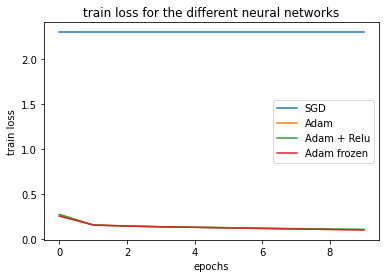

In [326]:
plt.plot(train_loss, label='SGD')
plt.plot(train_loss_net_adam, label='Adam')
plt.plot(train_loss_net2_adam, label='Adam + Relu')
plt.plot(train_loss_net3_adam, label='Adam frozen')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.title('train loss for the different neural networks')
plt.legend()
plt.show()

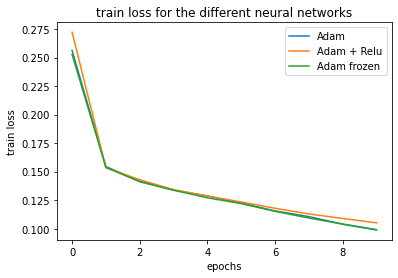

In [327]:
plt.plot(train_loss_net_adam, label='Adam')
plt.plot(train_loss_net2_adam, label='Adam + Relu')
plt.plot(train_loss_net3_adam, label='Adam frozen')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.title('train loss for the different neural networks')
plt.legend()
plt.show()

### Overall Accuraccy

In [328]:
accuracies = [accuracy, accuracy_net_adam, accuracy_net2_adam, accuracy_net3_adam]

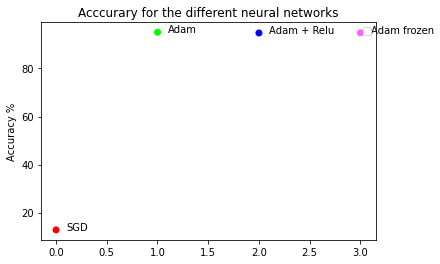

In [329]:
n = ["SGD", "Adam", "Adam + Relu", "Adam frozen"]
x = [0, 1, 2 ,3]
C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 100, 255]])
fig, ax = plt.subplots()
ax.scatter(x = x, y = accuracies, c = C/255.0)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i] + 0.1, accuracies[i]))
    
plt.ylabel("Accuracy %")
plt.title("Acccurary for the different neural networks")
plt.legend()

In [330]:
accuracies2 = [accuracy_net_adam, accuracy_net2_adam, accuracy_net3_adam]

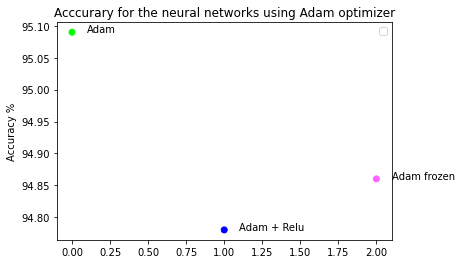

In [331]:
n = ["Adam", "Adam + Relu", "Adam frozen"]
x = [0, 1, 2 ]
C = np.array([[0, 255, 0], [0, 0, 255], [255, 100, 255]])
fig, ax = plt.subplots()
ax.scatter(x = x, y = accuracies2, c=C/255.0)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i] + 0.1, accuracies2[i]))
    
plt.ylabel("Accuracy %")
plt.title("Acccurary for the neural networks using Adam optimizer")
plt.legend()

Adding more layers and choosing different activation functions did not improve the results. We clearly identify the seconde try to be best neural network from the infomation we have. The Adam optimizer is fare more interesting. 

# Question 7 :

We create a function to plot the image we are wondering about : 

In [297]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

We downloaded the hymenoptera file from the this link ```https://download.pytorch.org/tutorial/hymenoptera_data.zip```

As we could not download file bigger than 15 Mb, we use the **request** librairy to do so : 

In [298]:
# import requests

# url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
# r = requests.get(url, allow_redirects=True)

# open('hymenoptera_data.zip', 'wb').write(r.content)

We then **unzip** the result : 

In [299]:
# from zipfile import ZipFile

# with ZipFile('hymenoptera_data.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

We load the **hymenoptera** datasets : 

In [300]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(os.getcwd(), 'hymenoptera_data', x), clip_preprocess) for x in ['train', 'val']}

We get the classes ```ants``` and ```bees``` from the datasets.

In [301]:
classes = image_datasets['train'].classes

We load the correspondind dataloaders.

In [302]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4) for x in ['train', 'val']}

We wonder about the training part : 

In [303]:
train_inputs = dataloaders['train']

We gather one image and its correponding class : 

In [304]:
one_image, one_class = next(iter(dataloaders['train']))

In [305]:
one_image = one_image.to(device)

```clip.tokenize``` tranform the test into a longTensor so that it can be used by the clip model. ```torch.cat``` concatenate the results : 

In [306]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

We use the clip model to get the enconding of both image and text

In [307]:
with torch.no_grad(): # We do not need to update the weigths
    image_features = model.encode_image(one_image) 
    text_features = model.encode_text(text_inputs)

We divide by the norm : 

In [308]:
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True) # We divide by the norm 
text_features /= text_features.norm(dim=-1, keepdim=True) # We divide by the norm 

We get the **cosine similarity** : 

In [309]:
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

We print the similarity for the two classes of the datasets and we check the result with the image :  


Top predictions:

            bees : 100.00%
            ants : 0.01%


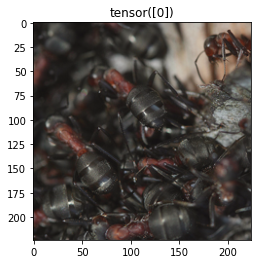

In [310]:
values, indices = similarity[0].topk(2)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{classes[index]:>16s} : {100*value.item():.2f}%")
out = torchvision.utils.make_grid(one_input)
imshow(out, title=classe)

# Question 8 : 

In [316]:
from torchvision.datasets import CIFAR100
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

Files already downloaded and verified


In [319]:
# Prepare the inputs
images = []
labels = []

#Recover a sample of images
for i in range(1000): #can be modified, but the kernel might crash for larger size
    image, class_id = cifar100[np.random.randint(low = 0, high = 50000)] #random sample
    images.append(image)
    labels.append(cifar100.classes[class_id])
image_input = torch.tensor(np.stack(images)).to(device)

#Recover label classes of cifar100
text_descriptions = cifar100.classes
text_tokens = clip.tokenize(text_descriptions).to(device)

# Calculate features (embedding in the same space)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# Normalize
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

We then want to choose the best label class that we can associate to each image in this new space. A way to do this, as in CLIP, is to use cosine similarity : we compute the scalar products and take the highest ($cos(\theta) = \frac{X.Y}{\lVert X \rVert \lVert Y \rVert}$ close to 1 stands for colinearity).

In [320]:
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1) #softmax operator used to get probabilities
top_probs, top_labels = similarity.cpu().topk(1, dim=-1)

pred = [cifar100.classes[i] for i in top_labels] #predicted labels

# Compute accuracy comparing with the true labels
accuracy = np.mean([float(labels[i] == pred[i]) for i in range(len(labels))]) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 58.100

We want to check other methods to compare the embeddings associated to images and texts. As they live in the same space, we want to try dimension reduction with PCA, then choose the nearest text neighbour for each image and compute the accuracy. We use the same inputs.

In [321]:
data = torch.cat((image_features, text_features), 0).cpu().detach().numpy() #concatenate images and texts (same shape)
pca = PCA(n_components=2) #Perfom PCA with sklearn
df = pd.DataFrame(data)
pca_result = pca.fit_transform(df)
top_labels = []
#Compute the nearest label for each image in the low dimensional representation induced by PCA
for i in range(len(labels)):
    dist = np.array([np.linalg.norm(pca_result[i, :] - pca_result[j, :]) for j in range(len(labels), len(labels)+100)])
    nntxt = np.argmax(dist)
    top_labels.append(nntxt)


In [322]:
#Compute accuracy
pred = [cifar100.classes[i] for i in top_labels]
# Evaluate using the logistic regression classifier
accuracy = np.mean([float(labels[i] == pred[i]) for i in range(len(labels))]) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 0.700

Compared to cosine similarity on the whole space, PCA performs doesn't perfom at all. We can try to do PCA in a higher dimensional space :

In [323]:
data = torch.cat((image_features, text_features), 0).cpu().detach().numpy() #concatenate images and texts (same shape)
pca = PCA(n_components=10) #Perfom PCA with sklearn
df = pd.DataFrame(data)
pca_result = pca.fit_transform(df)
top_labels = []
#Compute the nearest label for each image in the low dimensional representation induced by PCA
for i in range(len(labels)):
    dist = np.array([np.linalg.norm(pca_result[i, :] - pca_result[j, :]) for j in range(len(labels), len(labels)+100)])
    nntxt = np.argmax(dist)
    top_labels.append(nntxt)
    
    #Compute accuracy
pred = [cifar100.classes[i] for i in top_labels]
# Evaluate using the logistic regression classifier
accuracy = np.mean([float(labels[i] == pred[i]) for i in range(len(labels))]) * 100.
print(f"Accuracy = {accuracy:.3f}")


Accuracy = 0.000

This is even worse ! We can try to combine PCA with cosine similarity instead of the euclidean distance in the induced eigeinspaces.

In [324]:
data = torch.cat((image_features, text_features), 0).cpu().detach().numpy() #concatenate images and texts (same shape)
pca = PCA(n_components=50) #Perfom PCA with sklearn
df = pd.DataFrame(data)
pca_result = pca.fit_transform(df)
top_labels = []
#Compute the nearest label for each image in the low dimensional representation induced by PCA
for i in range(len(labels)):
    dist = np.array([100*(pca_result[i, :].dot(pca_result[j, :])) for j in range(len(labels), len(labels)+100)])
    nntxt = np.argmax(dist)
    top_labels.append(nntxt)


In [325]:
#Compute accuracy
pred = [cifar100.classes[i] for i in top_labels]
# Evaluate using the logistic regression classifier
accuracy = np.mean([float(labels[i] == pred[i]) for i in range(len(labels))]) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 49.300

Works better for high dimensional PCA. But no gain compared to cosine similarity alone....